### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Apr 3rd at 11.59pm CST
---

## Problem 1

This problem has to do with density estimation and clustering. 

**1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels.** 


**2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution.**


**3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?**


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [202]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for sigma in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]), 2 * sigma * sigma1, 2 * sigma * sigma2, alpha * 180. / np.pi, **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [23]:
### IMPORTS
############
############

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

### Part 1

In [165]:
#CLD reading in the data
data = np.load('../../homeworks/hw_data/hw6_data_1.npy')

#CLD splitting the data up into its sections
feat1 = data[:,0]
feat2 = data[:,1]
label = data[:,2]

feats = data[:,:2]

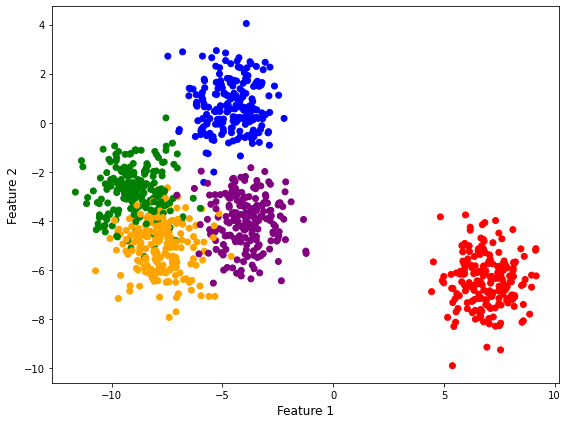

In [166]:
#CLD making a 2d scatter plot of feature 2 vs feature 1 with the labels acting as a colorbar
fig, ax = plt.subplots(figsize=(8,6))

#CLD arbitraily assinging labels to colors
#CLD also the labels go from 0 to 4, so five colors needed
colors = ['red', 'green', 'blue', 'purple', 'orange']

ax.scatter(feat1, feat2, c=label, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
fig.tight_layout()
plt.show(fig);

### Part 2

In [167]:
#CLD starting the kernel density estimation
K = 5 #CLD how many cross validations we want to do
bw_grid = np.linspace(0.1, 1.0, 30) #CLD the bandwidth grid to cross validate over
grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_grid}, cv=K) #CLD finding the optimal bandwidth

grid.fit(feats)

bw = grid.best_params_['bandwidth']
print('The best bandwidth is: %.2f' % bw)

The best bandwidth is: 0.47


<ipython-input-176-f829eb3ae7f8>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(x, y))).T


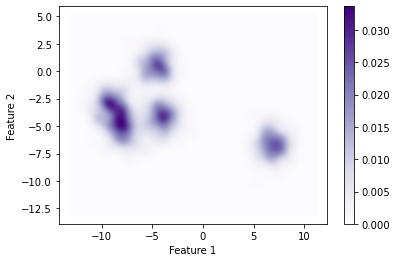

In [176]:
#CLD plotting this kernel denisty estimation with the best bandwidth
#CLD instantianting the model
kde = KernelDensity(kernel='gaussian', bandwidth=bw)
kde.fit(feats) #CLD fitting the features data

#CLD making a grid to plot the kde
x = np.linspace(-13, 11, 200)
y = np.linspace(-13, 5, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(x, y))).T
dens = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show();

### Part 3

In [89]:
#CLD importing the needed code
from astroML.density_estimation import KNeighborsDensity

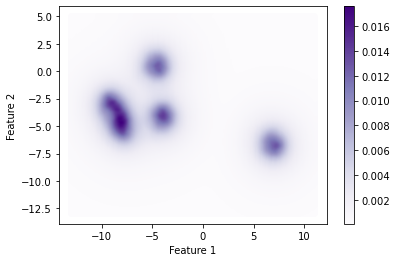

In [181]:
k = 100 #CLD the number of neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(feats)

#CLD plotting the density estimation in 2D
dens_nbrs = nbrs.eval(Xgrid) / feats.size
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show();

I found that you would need about k=100 nearest neighboors for it to look like the KDE 2D histogram.

### Part 4

In [92]:
#CLD importing the gaussian mixture model
from sklearn.mixture import GaussianMixture

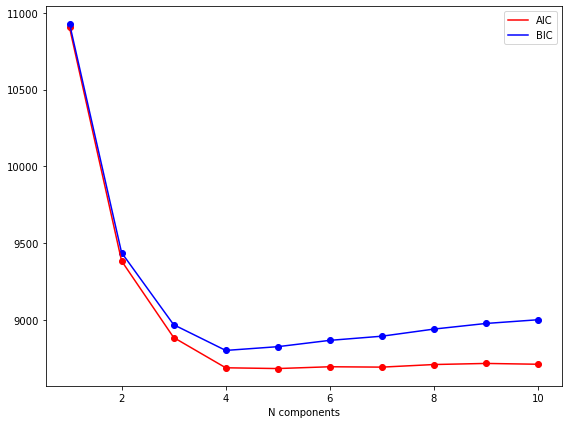

The minimum BIC happens at 4 components.


In [283]:
#CLD making a grid of the number of components
n_grid = [1,2,3,4,5,6,7,8,9,10]

models = []
for n in n_grid:
    model = GaussianMixture(int(n)).fit(feats)
    models.append(model)
    
#CLD computing the AIC
AIC = [m.aic(feats) for m in models]

#CLD computing the BIC
BIC = [m.bic(feats) for m in models]

#CLD plotting the AIC and BIC vs number of components
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(n_grid, AIC, c='r', label='AIC')
ax.scatter(n_grid, AIC, c='r')
ax.plot(n_grid, BIC, label='BIC', c='b')
ax.scatter(n_grid, BIC, c='b')
ax.set_xlabel('N components')
ax.legend()
fig.tight_layout()
plt.show()

print('The minimum BIC happens at '+str(n_grid[np.argmin(BIC)])+' components.')

The smaller BIC/AIC value wins. In this case, this happens at 4 components as seen on the graph above and in the printed statment.

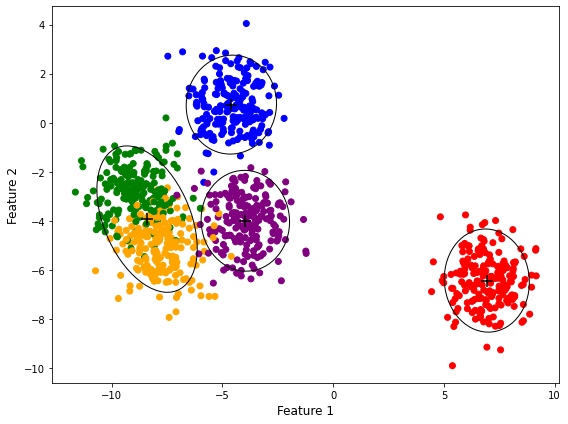

In [261]:
#CLD fitting to the gaussian mixture model with 4 components
gmm = GaussianMixture(4)
gmm.fit(feats)

#CLD plotting it
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(feat1, feat2, c=label, cmap=matplotlib.colors.ListedColormap(colors))
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], c='k', marker='+', s=150)
for i in range(4):
    draw_ellipse(gmm.means_[i], gmm.covariances_[i], sigmas=[2], fill=False)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
fig.tight_layout()
plt.show(fig);

### Part 5

In [104]:
#CLD importing the Kmeans function and the preprocessing obj which has the standard scalar function
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [206]:
n_clusters = 5
scaler = preprocessing.StandardScaler() #CLD instantitating the scaling function
clf = KMeans(n_clusters) #CLD instantiating the Kmeans function with the proper number of clusters
clf.fit(scaler.fit_transform(feats))

KMeans(n_clusters=5)

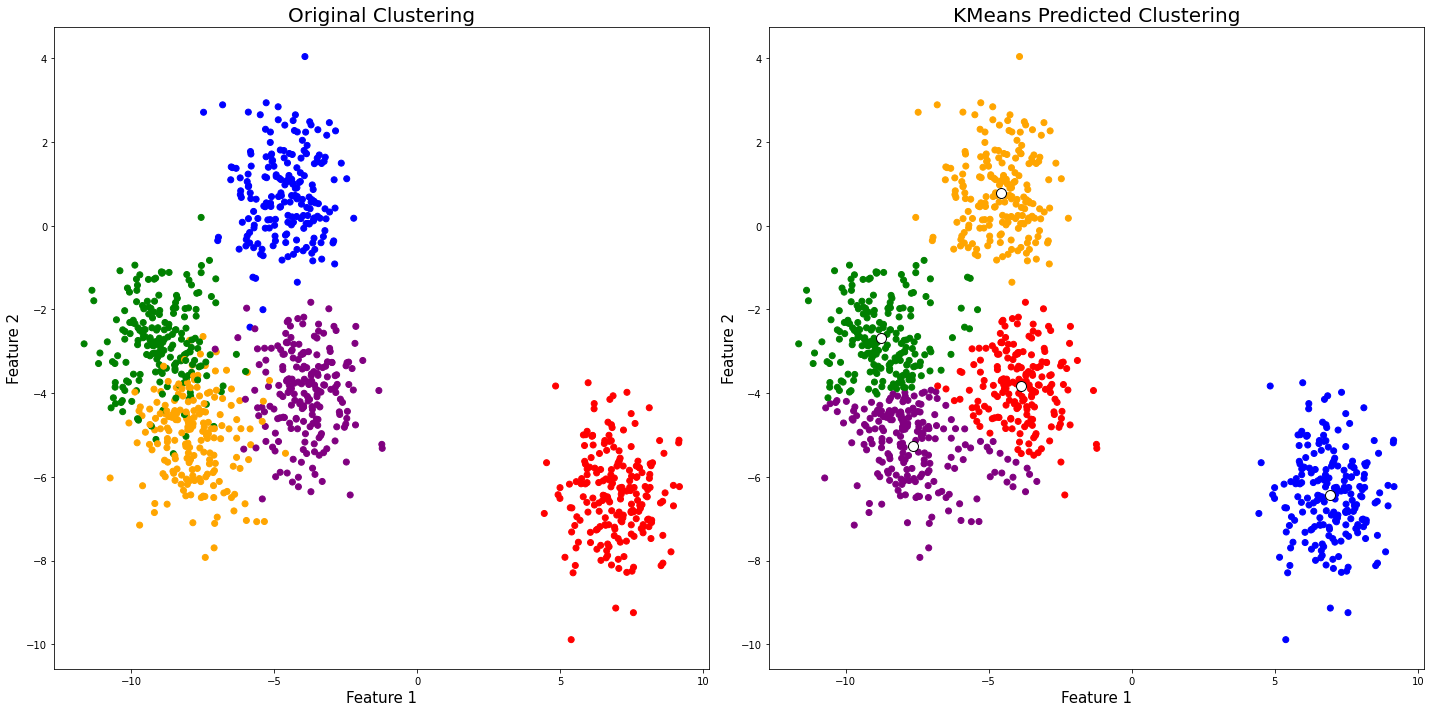

In [214]:
#CLD to find the cluster centers use the inverse transform feat of the scaler obj on the found cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)

#CLD or maybe use .labels_?
pred_labels = clf.labels_

#CLD plotting everything
colors = ['red', 'green', 'blue', 'purple', 'orange']

fig,ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(feat1, feat2, c=label, cmap=matplotlib.colors.ListedColormap(colors))
ax[0].set_xlabel('Feature 1', fontsize=15)
ax[0].set_ylabel('Feature 2', fontsize=15)
ax[0].set_title('Original Clustering', fontsize=20)
ax[1].scatter(feat1, feat2, c=pred_labels, cmap=matplotlib.colors.ListedColormap(colors))
ax[1].scatter(cluster_centers[:,0], cluster_centers[:,1], s=100, c='w', edgecolors='k')
ax[1].set_xlabel('Feature 1', fontsize=15)
ax[1].set_ylabel('Feature 2', fontsize=15)
ax[1].set_title('KMeans Predicted Clustering', fontsize=20)
fig.tight_layout()
plt.show(fig);

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

**1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.**

In [228]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


**2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?**


**3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.**


**4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)***


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

In [46]:
#CLD using pca to reduce down to 2 features
pca = PCA(n_components=2) #CLD want to reduce it to 2 features
pca.fit(X) #CLD fitting X

evals = pca.explained_variance_ratio_ #CLD calling this will read out the explained variance
print('The explained variance for all of the data in these eigenfeatures is: '+str(sum(evals)))

The explained variance for all of the data in these eigenfeatures is: 0.7833146203950654


In [29]:
#CLD making an array out of the labels
labels = np.asarray(data['type'])
print(np.unique(labels))

[3 6]


From above, the two integer labels are 3 and 6. Based on the astroML documentation, the type keyword repersents the return of a query from the photoTag view provided by SDSS that specifies if an object is resolved or not. From the SDSS schema browser for PhotoTag, 3 repersents a type classification of galaxy and 6 repersents a type classification of a star/point source.

5000


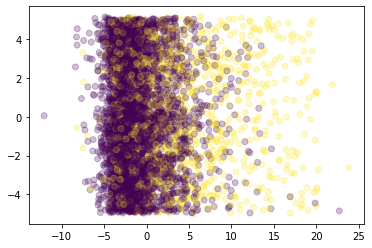

In [263]:
#CLD choosing 5000 random int from 0 to number of samples in data
int_ind = np.random.choice(range(len(data)), 5000, replace=False)#CLD can you reuse the same int?
print(len(np.unique(int_ind)))

#CLD transforming the randomly samples data
X_reduced = pca.transform(X[int_ind])

#CLD making the 2D scatter plot
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels[int_ind], alpha=0.25)
plt.show();

In [264]:
#CLD making a subarray of the randomly choosen samples so I don't have to worry about splicing each time
samples = X[int_ind]
sample_labels = labels[int_ind]

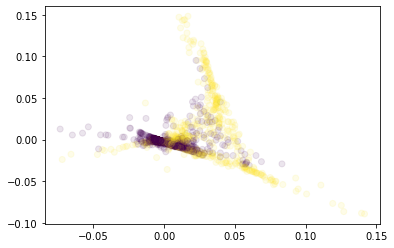

In [266]:
#CLD trying the same stuff from above but using LocallyLinearEmbedding
from sklearn.manifold import LocallyLinearEmbedding

n = 2 #CLD the number of features
k = 5 #CLD trying 5 nearest neighbors first

lle = LocallyLinearEmbedding(n_neighbors=k, n_components=n) #CLD instanstiazing the model

lle.fit(samples) #CLD fitting to model
samples_reduced_lle = lle.transform(samples) 

plt.scatter(samples_reduced_lle[:,0], samples_reduced_lle[:,1], c=sample_labels, alpha=0.1)
plt.show();

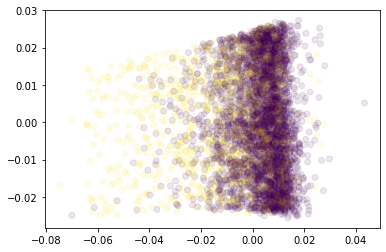

In [267]:
#CLD doing the same thing but for 50
n = 2 #CLD the number of features
k = 50 #CLD trying 50 nearest neighbors first

lle = LocallyLinearEmbedding(n_neighbors=k, n_components=n) #CLD instanstiazing the model

lle.fit(samples) #CLD fitting to model
samples_reduced_lle = lle.transform(samples) 

plt.scatter(samples_reduced_lle[:,0], samples_reduced_lle[:,1], c=sample_labels, alpha=0.1)
plt.show();

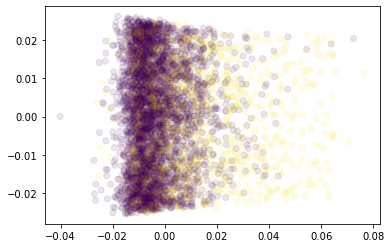

In [268]:
#CLD doing the same thing but for 100 k
n = 2 #CLD the number of features
k = 100 #CLD trying 100 nearest neighbors first

lle = LocallyLinearEmbedding(n_neighbors=k, n_components=n) #CLD instanstiazing the model

lle.fit(samples) #CLD fitting to model
samples_reduced_lle = lle.transform(samples) 

plt.scatter(samples_reduced_lle[:,0], samples_reduced_lle[:,1], c=sample_labels, alpha=0.1)
plt.show();

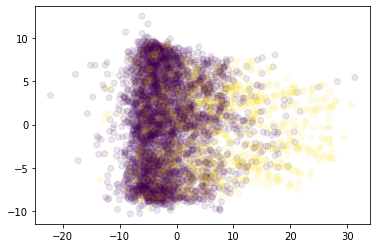

In [269]:
#CLD moving on to do the ISOMap analysis
from sklearn.manifold import Isomap

n = 2
k = 5 #CLD starting off with 5 again

iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(samples)

samples_reduced_iso = iso.transform(samples)

plt.scatter(samples_reduced_iso[:,0], samples_reduced_iso[:,1], c=sample_labels, alpha=0.1)
plt.show();

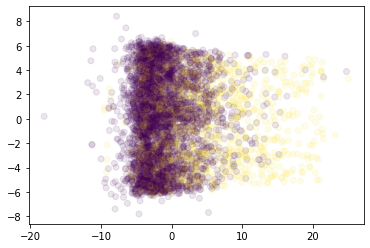

In [270]:
#CLD doing the above but with 50 nearest neighboors
n = 2
k = 50 #CLD starting off with 5 again

iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(samples)

samples_reduced_iso = iso.transform(samples)

plt.scatter(samples_reduced_iso[:,0], samples_reduced_iso[:,1], c=sample_labels, alpha=0.1)
plt.show();

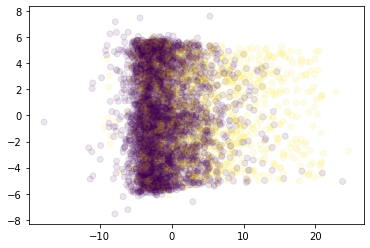

In [271]:
#CLD doing the same as above but with 100 nearest neighboors
n = 2
k = 100 #CLD starting off with 5 again

iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(samples)

samples_reduced_iso = iso.transform(samples)

plt.scatter(samples_reduced_iso[:,0], samples_reduced_iso[:,1], c=sample_labels, alpha=0.1)
plt.show();

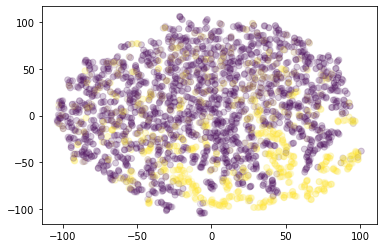

In [272]:
#CLD using the T-SNE reduction method on data set
from sklearn.manifold import TSNE

n = 2
perplex = 5 #CLD starting off the perplexity attribute at 5 same as above

tsne = TSNE(n_components=n, perplexity=perplex)

samples_reduced_t = tsne.fit_transform(samples)

plt.scatter(samples_reduced_t[:,0], samples_reduced_t[:,1], c=sample_labels, alpha=0.1)
plt.show();

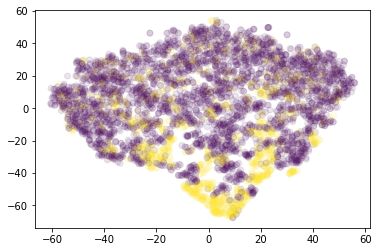

In [273]:
#CLD redoing above but with higher perplexity 
n = 2
perplex = 50 #CLD perplexity attribute of 50

tsne = TSNE(n_components=n, perplexity=perplex)

samples_reduced_t = tsne.fit_transform(samples)

plt.scatter(samples_reduced_t[:,0], samples_reduced_t[:,1], c=sample_labels, alpha=0.1)
plt.show();

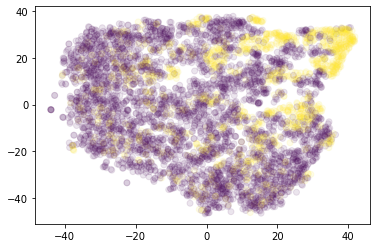

In [274]:
#CLD redoing above but with higher perplexity 
n = 2
perplex = 75 #CLD perplexity attribute of 100

tsne = TSNE(n_components=n, perplexity=perplex)

samples_reduced_t = tsne.fit_transform(samples)

plt.scatter(samples_reduced_t[:,0], samples_reduced_t[:,1], c=sample_labels, alpha=0.1)
plt.show();

After lowering the alpha of the points, it is relatively easy to see if the points are clustering effectively or not. For LLE and Isomap, there is never any clear seperating into distinct clusters. All of the points tend to lie in a single strip in the middle/side of the graph. Although yellow points do tend to scatter slightly to the edges, I would not call that distinct clustering by any means.

However, when looking at TSNE with low alpha, you can see that yellow points do cluster into distnct pockets within the purple. Because of this, I would choose this reduction algorithim for this sample set. Additionally, a preplexity of 50 seems sufficent enough. Past that, the run time increases by a fair amount without a siginificant improvement in clustering as can be seen by comparing a perplexity of 50 (the penultimate graph) and a preplexity of 75 (the final graph).